# World Bank Poverty Prediction
The [task](https://blogs.worldbank.org/opendata/data-science-competition-predicting-poverty-hard-can-you-do-it-better) is to measure poverty using the collection of detailed data on households. The marriage of machine learning (ML) techniques to lighter collection instruments may transform how the World Bank and its development partners approach poverty measurement. Predicting a household's poverty status with a handful of easy-to-collect qualitative variables lowers costs, decreases turnaround times, and, ultimately, creates a more solid empirical foundation for policy. In this notebook, I tried several different ML algorithms to fit the training data of country A, and calculated the log-loss scores based on the test data. Results ... /* TODO*/

## Import related packages

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

In [2]:
# read training data and show preview
a_train = pd.read_csv("worldbank_train_data.csv", index_col='id')
a_train.head()

,wBXbHZmp,SlDKnCuu,KAJOWiiw,DsKacCdL,rtPrBBPl,tMJrvvut,jdetlNNF,maLAYXwi,vwpsXRGk,sArDRIyX,...,sDGibZrP,CsGvKKBJ,OLpGAaEu,LrDrWRjC,JCDeZBXq,HGPWuGlV,GDUPaBQs,WuwrCsIY,AlDbXTlZ,country
id,,,,,,,,,,,,,,,,,,,,,
46107,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,XAmOF,MwLvg,...,JqHnW,MaXfS,etZsD,idRwx,LPtkN,vkbkA,qQxrL,AITFl,aQeIm,A
82739,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,lwCkE,MwLvg,...,JqHnW,MaXfS,HxnJy,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
9646,JhtDR,GUusz,BIZns,ZYabk,uxuSS,PHMVg,NDTCU,sehIp,qNABl,MwLvg,...,JqHnW,MaXfS,USRak,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
16463,JhtDR,alLXR,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,NdlDR,MwLvg,...,JqHnW,MaXfS,etZsD,idRwx,UyAms,vkbkA,qQxrL,GAZGl,aQeIm,A
98438,JhtDR,alLXR,BIZns,ZYabk,feupP,PHMVg,NDTCU,sehIp,bUhyU,MwLvg,...,JqHnW,MaXfS,HxnJy,idRwx,UyAms,vkbkA,qQxrL,AITFl,aQeIm,A


## Poverty Distribution

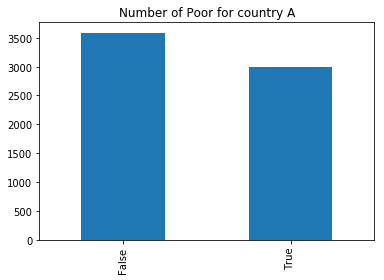

In [3]:
a_train.poor.value_counts().plot.bar(title='Number of Poor for country A')

In [4]:
a_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6578 entries, 46107 to 39832
Columns: 345 entries, wBXbHZmp to country
dtypes: bool(1), int64(4), object(340)
memory usage: 17.3+ MB


## Standarize Datasets

In [5]:
# Standardize features
def standardize(df, numeric_only=True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    
    # subtracy mean and divide by std
    df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()
    
    return df
    

def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
        
    df = standardize(df)
    print("After standardization {}".format(df.shape))
        
    # create dummy variables for categoricals
    df = pd.get_dummies(df)
    print("After converting categoricals:\t{}".format(df.shape))

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)

        df.drop(to_drop, axis=1, inplace=True)
        df = df.assign(**{c: 0 for c in to_add})
    
    df.fillna(0, inplace=True)
    
    return df

In [6]:
print("Country A")
aX_train = pre_process_data(a_train.drop('poor', axis=1))
ay_train = np.ravel(a_train.poor)

Country A
Input shape:	(6578, 344)
After standardization (6578, 344)
After converting categoricals:	(6578, 856)


## Random Forest

In [7]:
def train_model_RF(features, labels, **kwargs):
    
    # instantiate model
    model = RandomForestClassifier(n_estimators=50, random_state=0)
    
    # train model
    model.fit(features, labels)
    
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    print(f"In-sample accuracy: {accuracy:0.2%}")
    
    return model

In [8]:
model_a = train_model_RF(aX_train, ay_train)

In-sample accuracy: 100.00%


In [9]:
# load test data
a_test   = pd.read_csv("worldbank_test_data.csv", index_col='id')
ay_test = np.ravel(a_test.poor)

In [10]:
# preprocess the test data
a_test_RF = pre_process_data(a_test, enforce_cols=aX_train.columns)

Input shape:	(1625, 345)
After standardization (1625, 345)
After converting categoricals:	(1625, 846)


In [11]:
a_preds_RF = model_a.predict_proba(a_test_RF)

In [12]:
a_preds_RF

array([[0.76, 0.24],
       [0.74, 0.26],
       [0.72, 0.28],
       ...,
       [0.68, 0.32],
       [0.68, 0.32],
       [0.74, 0.26]])

In [13]:
ay_test = np.ravel(a_test.poor)
log_loss(ay_test, a_preds_RF)

0.7104481501833004

## LASSO tuning parameters

In [14]:
clf_lasso = linear_model.Lasso( alpha = 0.04 )
clf_lasso.fit(aX_train, ay_train)

Lasso(alpha=0.04, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [15]:
# preprocess the test data
a_test_LASSO = pre_process_data(a_test, enforce_cols=aX_train.columns)

Input shape:	(1625, 345)
After standardization (1625, 345)
After converting categoricals:	(1625, 846)


In [17]:
a_preds_LASSO = clf_lasso.predict(a_test_LASSO)

In [18]:
log_loss(ay_test, a_preds_LASSO)

0.5406033207901745

## Ridge

In [33]:
clf_rg = linear_model.Ridge(alpha=1.5)
clf_rg.fit(aX_train, ay_train) 
a_preds_Ridge = clf_rg.predict(a_test_LASSO)
log_loss(ay_test, a_preds_Ridge)

3.633141347685499

## SVM

In [20]:
from sklearn import svm

In [21]:
clf_svm = svm.SVC(gamma='scale')
clf_svm.fit(aX_train, ay_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
a_preds_SVM = clf_svm.predict(a_test_LASSO)
log_loss(ay_test, a_preds_SVM)

15.175806982133063

In [24]:
clf_svm.support_vectors_

array([[-1.46803554,  0.32558545,  1.11146059, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.61990777, -0.50054646, -0.00902796, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.61990777, -0.50054646, -0.00902796, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [-0.42406389,  0.32558545,  1.11146059, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.61990777,  0.32558545, -0.00902796, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.61990777, -0.50054646, -1.1295165 , ...,  0.        ,
         1.        ,  1.        ]])

## Bagging

## Neural Networks